# 📊 Customer Churn Prediction

This notebook demonstrates a **machine learning pipeline** for predicting customer churn in the telecom industry.  
The goal is to identify customers who are likely to leave, so that retention strategies can be applied.  

## 🔹 Dataset
- Source: [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn)  
- Records: 7,043 customers  
- Features: Demographic info, account details, and service usage  
- Target: **Churn** (Yes/No)

## 🔹 What this notebook covers
1. Data cleaning & preprocessing  
2. Exploratory Data Analysis (EDA)  
3. Feature engineering  
4. Handling class imbalance with **SMOTE**  
5. Training and evaluating multiple models  
6. Comparing different pipeline configurations  
7. Selecting the best model based on recall (focus on churn detection)  

In [1]:
"""
Simplified Churn Prediction Pipeline
Single-line execution with configurable parameters
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, classification_report, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline  # For handling SMOTE in CV

# Optional imports
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

class ChurnPipeline:
    """
    Simplified all-in-one churn prediction pipeline
    
    Usage:
        pipeline = ChurnPipeline('data.csv')
        results = pipeline.run()
    """
    
    def __init__(self, 
                 filepath,
                 target='Churn',
                 test_size=0.2,
                 use_feature_engineering=True,
                 use_smote=True,
                 models='all',
                 explore_data=True,
                 random_state=42,
                 verbose=True):
        """
        Initialize pipeline with configuration
        
        Args:
            filepath: Path to CSV file
            target: Target column name (default: 'Churn')
            test_size: Test split ratio (default: 0.2)
            use_feature_engineering: Add engineered features (default: True)
            use_smote: Apply SMOTE for imbalanced data (default: True)
            models: List of model names or 'all' (default: 'all')
                   Options: ['logistic', 'rf', 'gb', 'svm', 'knn', 'nb', 'xgboost']
            explore_data: Show EDA visualizations (default: True)
            random_state: Random seed (default: 42)
            verbose: Print progress (default: True)
        """
        self.filepath = filepath
        self.target = target
        self.test_size = test_size
        self.use_feature_engineering = use_feature_engineering
        self.use_smote = use_smote
        self.models_to_use = models
        self.explore_data = explore_data
        self.random_state = random_state
        self.verbose = verbose
        
        # Data storage
        self.df = None
        self.df_processed = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        # Model storage
        self.models = {}
        self.results = {}
        self.best_model = None
        self.best_model_name = None
        
        # Encoders
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.scaler = StandardScaler()
        self.feature_names = None
    
    def _print(self, message):
        """Helper for conditional printing"""
        if self.verbose:
            print(message)
    
    def load_and_clean_data(self):
        """Load and perform basic cleaning"""
        self.df = pd.read_csv(self.filepath)
        self._print(f"✅ Loaded data: {self.df.shape}")
        
        # Basic info
        if self.verbose:
            print("\n📊 Data Info:")
            print(f"Shape: {self.df.shape}")
            print(f"Missing values:\n{self.df.isnull().sum()[self.df.isnull().sum() > 0]}")
        
        # Drop customerID
        if 'customerID' in self.df.columns:
            self.df = self.df.drop('customerID', axis=1)
        
        # Fix TotalCharges (convert to numeric, fill blanks with 0)
        if 'TotalCharges' in self.df.columns:
            self.df['TotalCharges'] = pd.to_numeric(self.df['TotalCharges'], errors='coerce')
            self.df['TotalCharges'] = self.df['TotalCharges'].fillna(0)

        if self.df['SeniorCitizen'].dtype != 'object':
                self.df['SeniorCitizen'] = self.df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
        
        self._print(f"✅ Data cleaned: {self.df.shape}")
        return self
    
    def explore(self):
        """Perform exploratory data analysis"""
        if not self.explore_data:
            return self
        
        df = self.df.copy()
        
        # 1. Churn Distribution
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Pie chart
        churn_counts = df[self.target].value_counts()
        axes[0].pie(churn_counts.values, labels=churn_counts.index, 
                   autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
        axes[0].set_title('Churn Distribution')
        
        # Key numeric features
        if 'tenure' in df.columns:
            df.boxplot(column='tenure', by=self.target, ax=axes[1])
            axes[1].set_title('Tenure by Churn')
            axes[1].set_xlabel('')
            axes[1].set_ylabel('Tenure (months)')
        
        if 'MonthlyCharges' in df.columns:
            df.boxplot(column='MonthlyCharges', by=self.target, ax=axes[2])
            axes[2].set_title('Monthly Charges by Churn')
            axes[2].set_xlabel('')
            axes[2].set_ylabel('Monthly Charges ($)')
        
        plt.suptitle('')
        plt.tight_layout()
        plt.show()
        
        # 2. Categorical features vs Churn
        categorical_cols = ['Contract', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'TechSupport']
        available_cols = [col for col in categorical_cols if col in df.columns]
        
        if available_cols:
            fig, axes = plt.subplots(1, len(available_cols), figsize=(15, 4))
            if len(available_cols) == 1:
                axes = [axes]
            
            for idx, col in enumerate(available_cols):
                churn_by_cat = df.groupby([col, self.target]).size().unstack()
                churn_by_cat.plot(kind='bar', stacked=True, ax=axes[idx], 
                                 color=['#2ecc71', '#e74c3c'], legend=(idx==0))
                axes[idx].set_title(f'{col}')
                axes[idx].set_xlabel('')
                axes[idx].set_ylabel('Count')
                axes[idx].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()
        
        # 3. Correlation heatmap for numeric features
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            plt.figure(figsize=(8, 6))
            # Convert target to numeric for correlation
            df_corr = df.copy()
            df_corr[self.target] = (df_corr[self.target] == 'Yes').astype(int)
            correlation = df_corr[list(numeric_cols) + [self.target]].corr()
            sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
            plt.title('Feature Correlations')
            plt.tight_layout()
            plt.show()
        
        # 4. Churn risk summary
        self._print("\n📊 Churn Risk Analysis:")
        risk_features = ['Contract', 'PaymentMethod', 'OnlineSecurity', 'TechSupport', 'tenure']
        for feature in risk_features:
            if feature in df.columns:
                if feature == 'tenure':
                    # Bin tenure for analysis
                    tenure_bins = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                                        labels=['0-1yr', '1-2yr', '2-4yr', '4+yr'])
                    churn_rate = df.groupby(tenure_bins)[self.target].apply(lambda x: (x=='Yes').mean() * 100)
                    self._print(f"\n{feature} (grouped):")
                else:
                    churn_rate = df.groupby(feature)[self.target].apply(lambda x: (x=='Yes').mean() * 100)
                    self._print(f"\n{feature}:")
                for idx, rate in churn_rate.items():
                    risk_level = "🔴 HIGH" if rate > 40 else "🟡 MEDIUM" if rate > 25 else "🟢 LOW"
                    self._print(f"  {idx}: {rate:.1f}% {risk_level}")
        
        return self
    
    def engineer_features(self):
        """Add engineered features for better prediction"""
        if not self.use_feature_engineering:
            self.df_processed = self.df.copy()
            return self
        
        df = self.df.copy()
        
        # Risk indicators
        if 'OnlineSecurity' in df.columns:
            df['no_online_security'] = (df['OnlineSecurity'] == 'No').astype(int)
        if 'TechSupport' in df.columns:
            df['no_tech_support'] = (df['TechSupport'] == 'No').astype(int)
        if 'Contract' in df.columns:
            df['month_to_month'] = (df['Contract'] == 'Month-to-month').astype(int)
        if 'PaymentMethod' in df.columns:
            df['electronic_check'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
        
        # Service engagement
        service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
        if all(col in df.columns for col in service_cols):
            df['services_count'] = sum((df[col] == 'Yes').astype(int) for col in service_cols)
        
        # Customer profile
        if 'Partner' in df.columns and 'Dependents' in df.columns:
            df['is_alone'] = ((df['Partner'] == 'No') & (df['Dependents'] == 'No')).astype(int)
        
        # Tenure groups
        if 'tenure' in df.columns:
            df['tenure_group'] = pd.cut(df['tenure'], 
                                       bins=[-1, 12, 24, 48, 72], 
                                       labels=['0-1yr', '1-2yr', '2-4yr', '4+yr'])
        
        # Value indicators
        if 'TotalCharges' in df.columns and 'tenure' in df.columns:
            df['avg_charges'] = df['TotalCharges'] / (df['tenure'] + 1)
        
        self._print(f"✅ Features engineered: {df.shape[1] - self.df.shape[1]} new features added")
        self.df_processed = df
        return self
    
    def prepare_data(self):
        """Split, encode and scale data"""
        df = self.df_processed.copy()
        
        # Separate features and target
        X = df.drop(self.target, axis=1)
        y = (df[self.target] == 'Yes').astype(int)
        
        # Split BEFORE encoding/scaling
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        self._print(f"✅ Train-test split: Train {X_train.shape}, Test {X_test.shape}")
        
        # Separate numeric and categorical columns
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
        
        # Process training data
        X_train_processed = pd.DataFrame(index=X_train.index)
        X_test_processed = pd.DataFrame(index=X_test.index)
        
        # Add numeric features (scale them)
        if numeric_cols:
            X_train_scaled = self.scaler.fit_transform(X_train[numeric_cols])
            X_test_scaled = self.scaler.transform(X_test[numeric_cols])
            
            X_train_processed[numeric_cols] = X_train_scaled
            X_test_processed[numeric_cols] = X_test_scaled
        
        # One-hot encode categorical features
        if categorical_cols:
            X_train_encoded = self.encoder.fit_transform(X_train[categorical_cols])
            X_test_encoded = self.encoder.transform(X_test[categorical_cols])
            
            # Get feature names
            encoded_features = self.encoder.get_feature_names_out(categorical_cols)
            
            # Add to processed dataframes
            X_train_processed[encoded_features] = X_train_encoded
            X_test_processed[encoded_features] = X_test_encoded
        
        self.feature_names = X_train_processed.columns.tolist()
        self._print(f"✅ Features after encoding: {len(self.feature_names)} total")
        
        # Apply SMOTE if requested
        if self.use_smote:
            smote = SMOTE(random_state=self.random_state)
            X_train_processed, y_train = smote.fit_resample(X_train_processed, y_train)
            self._print(f"✅ SMOTE applied: {X_train_processed.shape[0]} samples (balanced)")
        
        # Store processed data
        self.X_train = X_train_processed
        self.X_test = X_test_processed
        self.y_train = y_train
        self.y_test = y_test
        
        return self
    
    def train_models(self):
        """Train all selected models with cross-validation, improved hyperparameter tuning, and a voting classifier"""
        # Define available models with more conservative parameter grids
        available_models = {
            'logistic': {
                'model': LogisticRegression(random_state=self.random_state, max_iter=1000),
                'params': {
                    'C': [0.01, 0.1, 1, 10],  # Wider range including stronger regularization
                    'solver': ['liblinear'],
                    'penalty': ['l1', 'l2']  # Try different regularization types
                }
            },
            'rf': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 5, None],
                    'min_samples_split': [5, 10, 20],  # Higher values for more regularization
                    'min_samples_leaf': [2, 5, 10],    # Higher values for more regularization
                    'max_features': ['sqrt', 0.5, 0.3]  # Limit features to prevent overfitting
                }
            },
            'gb': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rates
                    'max_depth': [3, 4],
                    'subsample': [0.7, 0.8, 0.9],  # Lower values for more regularization
                    'min_samples_split': [10, 20],  # Higher values for more regularization
                    'min_samples_leaf': [5, 10]     # Higher values for more regularization
                }
            },
            'svm': {
                'model': SVC(probability=True, random_state=self.random_state),
                'params': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto', 0.01, 0.001],  # Include smaller gamma values
                    'kernel': ['rbf']
                }
            },
            'knn': {
                'model': KNeighborsClassifier(),
                'params': {
                    'n_neighbors': [5, 7, 9, 11, 13],  # Include more neighbors
                    'weights': ['uniform', 'distance'],
                    'p': [1, 2]
                }
            },
            'nb': {
                'model': GaussianNB(),
                'params': {
                    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Add smoothing parameter tuning
                }
            }
        }
        
        if HAS_XGBOOST:
            available_models['xgboost'] = {
                'model': XGBClassifier(
                    eval_metric='auc',
                    use_label_encoder=False,
                    random_state=self.random_state,
                    verbosity=0
                ),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 4, 5],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'subsample': [0.7, 0.8, 0.9],
                    'colsample_bytree': [0.7, 0.8, 0.9],
                    'reg_alpha': [0, 0.1, 1],  # L1 regularization
                    'reg_lambda': [0, 0.1, 1]  # L2 regularization
                }
            }
        
        # Select models to train
        if self.models_to_use == 'all':
            models_to_train = available_models
        else:
            models_to_train = {k: v for k, v in available_models.items() if k in self.models_to_use}
        
        self._print(f"\n🚀 Training {len(models_to_train)} models with improved hyperparameter tuning...")
        self._print("="*60)
        
        # Use a different random state for tuning to avoid overfitting to a specific CV split
        tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state + 1)
        eval_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        self.results = {}
        trained_models = {}  # Store trained models for voting classifier
        
        for name, model_info in models_to_train.items():
            self._print(f"\nTraining {name}...")
            
            try:
                # Apply SMOTE to training data if needed
                if self.use_smote:
                    smote = SMOTE(random_state=self.random_state)
                    X_train_resampled, y_train_resampled = smote.fit_resample(self.X_train, self.y_train)
                else:
                    X_train_resampled, y_train_resampled = self.X_train, self.y_train
                
                # Create a pipeline that includes preprocessing to avoid data leakage
                if self.use_smote:
                    # Create a pipeline with SMOTE and the model
                    pipeline = ImbPipeline([
                        ('smote', SMOTE(random_state=self.random_state)),
                        ('model', model_info['model'])
                    ])
                    # Update parameter names for the pipeline
                    tuned_params = {f'model__{k}': v for k, v in model_info['params'].items()}
                else:
                    pipeline = model_info['model']
                    tuned_params = model_info['params']
                
                # Perform hyperparameter tuning with a balanced scoring metric
                if tuned_params:  # If there are parameters to tune
                    self._print(f"  🔍 Tuning hyperparameters for {name}...")
                    
                    # Use a combination of AUC and recall for scoring
                    scoring = {
                        'auc': 'roc_auc',
                        'recall': make_scorer(recall_score, pos_label=1),
                        'balanced_accuracy': 'balanced_accuracy'
                    }
                    
                    # Use RandomizedSearchCV for faster tuning
                    search = RandomizedSearchCV(
                        pipeline if self.use_smote else model_info['model'],
                        tuned_params,
                        n_iter=15,  # Reduced number of iterations
                        cv=tune_cv,
                        scoring=scoring,
                        refit='auc',  # Refit on AUC which is more robust
                        n_jobs=-1,
                        random_state=self.random_state,
                        verbose=0
                    )
                    
                    # Fit the search
                    search.fit(X_train_resampled, y_train_resampled)
                    
                    # Get the best model
                    final_model = search.best_estimator_
                    self._print(f"  ✅ Best parameters: {search.best_params_}")
                    self._print(f"  ✅ Best CV AUC: {search.best_score_:.3f}")
                    
                    # If using pipeline, extract just the model for voting classifier
                    if self.use_smote:
                        final_model = final_model.named_steps['model']
                else:
                    # No hyperparameters to tune, just use the model as is
                    final_model = clone(model_info['model'])
                    if self.use_smote:
                        final_model.fit(X_train_resampled, y_train_resampled)
                    else:
                        final_model.fit(self.X_train, self.y_train)
                
                # Store trained model for voting classifier
                trained_models[name] = final_model
                
                # Perform cross-validation for performance estimation (using different splits)
                cv_accuracies = []
                cv_aucs = []
                cv_recalls = []
                
                for train_idx, val_idx in eval_cv.split(X_train_resampled, y_train_resampled):
                    X_fold_train, X_fold_val = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[val_idx]
                    y_fold_train, y_fold_val = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[val_idx]
                    
                    # Clone the model for each fold
                    fold_model = clone(final_model)
                    fold_model.fit(X_fold_train, y_fold_train)
                    
                    # Predict on validation fold
                    y_val_pred = fold_model.predict(X_fold_val)
                    y_val_proba = fold_model.predict_proba(X_fold_val)[:, 1] if hasattr(fold_model, 'predict_proba') else y_val_pred
                    
                    # Calculate metrics
                    cv_accuracies.append(accuracy_score(y_fold_val, y_val_pred))
                    cv_aucs.append(roc_auc_score(y_fold_val, y_val_proba))
                    cv_recalls.append(recall_score(y_fold_val, y_val_pred, pos_label=1))
                
                # Calculate mean CV scores
                cv_accuracy = np.mean(cv_accuracies)
                cv_auc = np.mean(cv_aucs)
                cv_recall = np.mean(cv_recalls)
                
                # Evaluate on test set
                y_test_pred = final_model.predict(self.X_test)
                y_test_proba = final_model.predict_proba(self.X_test)[:, 1] if hasattr(final_model, 'predict_proba') else y_test_pred
                test_accuracy = accuracy_score(self.y_test, y_test_pred)
                test_auc = roc_auc_score(self.y_test, y_test_proba)
                test_recall = recall_score(self.y_test, y_test_pred, pos_label=1)
                
                # Store results
                self.results[name] = {
                    'model': final_model,
                    'cv_accuracy': cv_accuracy,
                    'cv_auc': cv_auc,
                    'cv_recall': cv_recall,
                    'test_accuracy': test_accuracy,
                    'test_auc': test_auc,
                    'test_recall': test_recall,
                    'predictions': y_test_pred,
                    'probabilities': y_test_proba,
                    'classification_report': classification_report(self.y_test, y_test_pred, 
                                                                target_names=['No Churn', 'Churn'])
                }
                
                self._print(f"  ✅ CV Accuracy: {cv_accuracy:.3f} (+/- {np.std(cv_accuracies) * 2:.3f})")
                self._print(f"  ✅ CV AUC: {cv_auc:.3f} (+/- {np.std(cv_aucs) * 2:.3f})")
                self._print(f"  ✅ CV Recall: {cv_recall:.3f} (+/- {np.std(cv_recalls) * 2:.3f})")
                self._print(f"  ✅ Test Accuracy: {test_accuracy:.3f}")
                self._print(f"  ✅ Test AUC: {test_auc:.3f}")
                self._print(f"  ✅ Test Recall: {test_recall:.3f}")
                
                # Check for overfitting
                cv_test_gap = abs(cv_auc - test_auc)
                if cv_test_gap > 0.1:
                    self._print(f"  ⚠️  Potential overfitting: CV-Test gap = {cv_test_gap:.3f}")
                
            except Exception as e:
                self._print(f"  ❌ Error training {name}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Create and train voting classifier if we have at least 2 models
        if len(trained_models) >= 2:
            self._print(f"\n🏗️  Creating Voting Classifier with {len(trained_models)} models...")
            
            # Create voting classifier with hard voting as requested
            voting_clf = VotingClassifier(
                estimators=list(trained_models.items()),
                voting='hard'
            )
            
            # Train voting classifier
            if self.use_smote:
                smote = SMOTE(random_state=self.random_state)
                X_train_resampled, y_train_resampled = smote.fit_resample(self.X_train, self.y_train)
                voting_clf.fit(X_train_resampled, y_train_resampled)
            else:
                voting_clf.fit(self.X_train, self.y_train)
            
            # Evaluate voting classifier
            y_test_pred_voting = voting_clf.predict(self.X_test)
            # For hard voting, we can't calculate probabilities, so we'll use the average of individual models' probabilities
            test_accuracy_voting = accuracy_score(self.y_test, y_test_pred_voting)
            test_recall_voting = recall_score(self.y_test, y_test_pred_voting, pos_label=1)
            
            # Calculate a pseudo-AUC for hard voting by averaging individual model probabilities
            all_probs = []
            for name, model in trained_models.items():
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba(self.X_test)[:, 1]
                    all_probs.append(probs)
            
            if all_probs:
                avg_probs = np.mean(all_probs, axis=0)
                test_auc_voting = roc_auc_score(self.y_test, avg_probs)
            else:
                test_auc_voting = None
            
            # Store voting classifier results
            self.results['voting'] = {
                'model': voting_clf,
                'test_accuracy': test_accuracy_voting,
                'test_auc': test_auc_voting,
                'test_recall': test_recall_voting,
                'predictions': y_test_pred_voting,
                'probabilities': avg_probs if all_probs else None,
                'classification_report': classification_report(self.y_test, y_test_pred_voting, 
                                                            target_names=['No Churn', 'Churn'])
            }
            
            self._print(f"  ✅ Voting Classifier Test Accuracy: {test_accuracy_voting:.3f}")
            if test_auc_voting is not None:
                self._print(f"  ✅ Voting Classifier Test AUC: {test_auc_voting:.3f}")
            self._print(f"  ✅ Voting Classifier Test Recall: {test_recall_voting:.3f}")
        
        # Find best model based on test recall (prioritizing churn detection)
        if self.results:
            # Filter out models with None values for test_auc
            valid_models = {k: v for k, v in self.results.items() if v['test_auc'] is not None}
            
            if valid_models:
                best_name = max(valid_models.keys(), key=lambda x: valid_models[x]['test_recall'])
                self.best_model = self.results[best_name]['model']
                self.best_model_name = best_name
                
                self._print(f"\n🏆 Best Individual Model: {best_name}")
                self._print(f"   Test AUC: {self.results[best_name]['test_auc']:.3f}")
                self._print(f"   Test Recall: {self.results[best_name]['test_recall']:.3f}")
                
                # Check if voting classifier is better than the best individual model
                if 'voting' in self.results and self.results['voting']['test_auc'] is not None:
                    voting_recall = self.results['voting']['test_recall']
                    if voting_recall > self.results[best_name]['test_recall']:
                        self._print(f"\n🏆 Voting Classifier outperforms individual models!")
                        self._print(f"   Voting Recall: {voting_recall:.3f} vs Best Individual: {self.results[best_name]['test_recall']:.3f}")
            else:
                self._print("\n❌ No valid models were successfully trained")
                self.best_model = None
                self.best_model_name = None
        else:
            self._print("\n❌ No models were successfully trained")
            self.best_model = None
            self.best_model_name = None
        
        return self
    
    def plot_results(self, show_plots=True):
        """Visualize model performance"""
        if not show_plots or not self.results:
            return self
        
        # Model comparison - 3 metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        model_names = list(self.results.keys())
        
        # Accuracy comparison
        accuracies = [self.results[m]['test_accuracy'] for m in model_names]  # Changed to test_accuracy
        axes[0].bar(model_names, accuracies, color='steelblue')
        axes[0].set_title('Model Accuracy (Test Set)')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_ylim([0.5, 1.0])
        axes[0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(accuracies):
            axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        # AUC comparison
        aucs = [self.results[m]['test_auc'] for m in model_names]  # Changed to test_auc
        axes[1].bar(model_names, aucs, color='darkgreen')
        axes[1].set_title('Model AUC Score (Test Set)')
        axes[1].set_ylabel('AUC')
        axes[1].set_ylim([0.5, 1.0])
        axes[1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(aucs):
            axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        # Churn Recall comparison
        recalls = [self.results[m]['test_recall'] for m in model_names]  # Changed to test_recall
        axes[2].bar(model_names, recalls, color='#e74c3c')
        axes[2].set_title('Churn Class Recall (Sensitivity) (Test Set)')
        axes[2].set_ylabel('Recall')
        axes[2].set_ylim([0.5, 1.0])
        axes[2].tick_params(axis='x', rotation=45)
        for i, v in enumerate(recalls):
            axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Confusion matrix for best model
        cm = confusion_matrix(self.y_test, self.results[self.best_model_name]['predictions'])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print detailed classification report for best model
        if self.verbose:
            print(f"\n📊 Classification Report - {self.best_model_name}:")
            print(self.results[self.best_model_name]['classification_report'])
        
        return self

    def get_feature_importance(self, top_n=15):
        """Get feature importance for tree-based models"""
        if self.best_model_name in ['rf', 'gb', 'xgboost']:
            importances = self.best_model.feature_importances_
            indices = np.argsort(importances)[::-1][:top_n]
            
            plt.figure(figsize=(10, 6))
            plt.title(f'Top {top_n} Feature Importances - {self.best_model_name}')
            plt.bar(range(len(indices)), importances[indices], color='steelblue')
            
            # Get feature names (handle one-hot encoded names)
            feature_names_display = []
            for i in indices:
                name = self.feature_names[i]
                # Simplify one-hot encoded names
                if '_' in name and name.split('_')[0] in ['Contract', 'PaymentMethod', 'InternetService']:
                    name = name.replace('_', ': ')
                feature_names_display.append(name)
            
            plt.xticks(range(len(indices)), feature_names_display, rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            if self.verbose:
                self._print(f"\nTop {top_n} Important Features:")
                for idx, i in enumerate(indices):
                    self._print(f"  {feature_names_display[idx]}: {importances[i]:.4f}")
        
        return self
    
    def run(self, show_plots=True, show_importance=True):
        """
        Run the complete pipeline
        
        Returns:
            Dictionary with results and best model
        """
        # Execute pipeline
        self.load_and_clean_data()
        self.explore()
        self.engineer_features()
        self.prepare_data()
        self.train_models()
        
        if show_plots and self.results:  # Only plot if we have results
            self.plot_results()
        
        if show_importance and self.best_model and self.best_model_name in ['rf', 'gb', 'xgboost']:
            self.get_feature_importance()
        
        # Return summary - handle case when no models were trained
        if self.best_model_name is not None:
            # Create all_results with safe access to CV metrics
            all_results = {}
            for k, v in self.results.items():
                result_entry = {
                    'test_accuracy': v['test_accuracy'],
                    'test_auc': v['test_auc'],
                    'test_recall': v['test_recall']
                }
                
                # Add CV metrics if they exist (they won't for the voting classifier)
                if 'cv_accuracy' in v:
                    result_entry['cv_accuracy'] = v['cv_accuracy']
                    result_entry['cv_auc'] = v['cv_auc']
                    result_entry['cv_recall'] = v['cv_recall']
                else:
                    result_entry['cv_accuracy'] = None
                    result_entry['cv_auc'] = None
                    result_entry['cv_recall'] = None
                    
                all_results[k] = result_entry
            
            return {
                'best_model': self.best_model_name,
                'best_auc': self.results[self.best_model_name]['test_auc'],
                'best_accuracy': self.results[self.best_model_name]['test_accuracy'],
                'best_churn_recall': self.results[self.best_model_name]['test_recall'],
                'all_results': all_results,
                'model_object': self.best_model,
                'full_results': self.results
            }
        else:
            return {
                'best_model': None,
                'best_auc': None,
                'best_accuracy': None,
                'best_churn_recall': None,
                'all_results': {},
                'model_object': None,
                'full_results': {}
            }

In [2]:
# ========== USAGE EXAMPLES ==========

def quick_run(filepath):
    """Quick run with all defaults"""
    pipeline = ChurnPipeline(filepath)
    return pipeline.run()

def compare_configurations(filepath):
    """Compare different configurations"""
    configs = [
        {'name': 'Baseline', 'use_feature_engineering': False, 'use_smote': False},
        {'name': 'With SMOTE', 'use_feature_engineering': False, 'use_smote': True},
        {'name': 'With Features', 'use_feature_engineering': True, 'use_smote': False},
        {'name': 'Full Pipeline', 'use_feature_engineering': True, 'use_smote': True},
    ]
    
    results_comparison = {}
    for config in configs:
        name = config.pop('name')
        print(f"\n{'='*50}")
        print(f"Testing: {name}")
        print('='*50)
        
        pipeline = ChurnPipeline(filepath, verbose=False, explore_data=False, **config)
        results = pipeline.run(show_plots=False, show_importance=False)
        results_comparison[name] = results
        
        print(f"Best Model: {results['best_model']}")
        print(f"AUC: {results['best_auc']:.3f}")
        print(f"Accuracy: {results['best_accuracy']:.3f}")
        print(f"Churn Recall: {results['best_churn_recall']:.3f}")
    
    return results_comparison

✅ Loaded data: (7043, 21)

📊 Data Info:
Shape: (7043, 21)
Missing values:
Series([], dtype: int64)
✅ Data cleaned: (7043, 20)


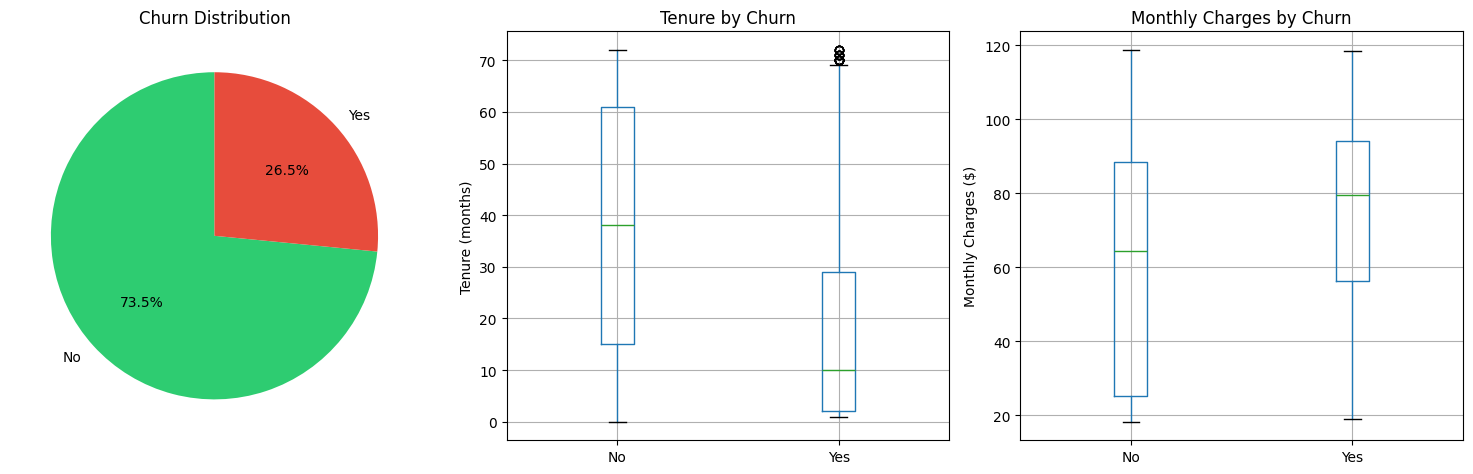

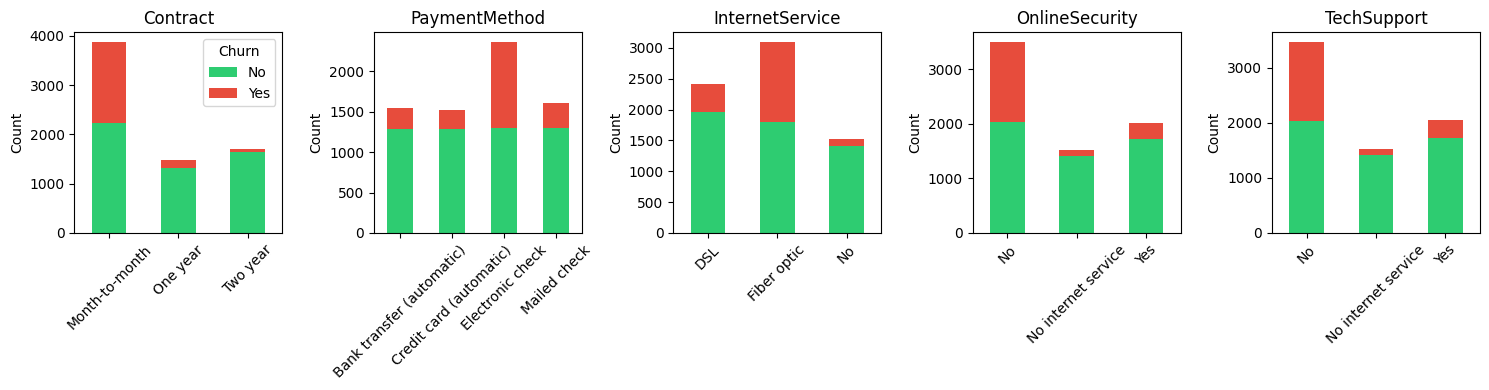

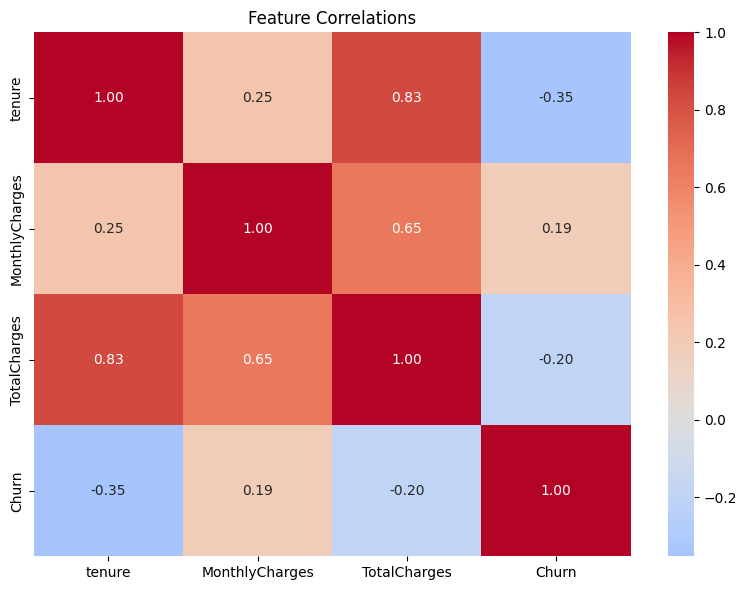


📊 Churn Risk Analysis:

Contract:
  Month-to-month: 42.7% 🔴 HIGH
  One year: 11.3% 🟢 LOW
  Two year: 2.8% 🟢 LOW

PaymentMethod:
  Bank transfer (automatic): 16.7% 🟢 LOW
  Credit card (automatic): 15.2% 🟢 LOW
  Electronic check: 45.3% 🔴 HIGH
  Mailed check: 19.1% 🟢 LOW

OnlineSecurity:
  No: 41.8% 🔴 HIGH
  No internet service: 7.4% 🟢 LOW
  Yes: 14.6% 🟢 LOW

TechSupport:
  No: 41.6% 🔴 HIGH
  No internet service: 7.4% 🟢 LOW
  Yes: 15.2% 🟢 LOW

tenure (grouped):
  0-1yr: 47.7% 🔴 HIGH
  1-2yr: 28.7% 🟡 MEDIUM
  2-4yr: 20.4% 🟢 LOW
  4+yr: 9.5% 🟢 LOW
✅ Features engineered: 8 new features added
✅ Train-test split: Train (5634, 27), Test (1409, 27)
✅ Features after encoding: 53 total
✅ SMOTE applied: 8278 samples (balanced)

🚀 Training 7 models with improved hyperparameter tuning...

Training logistic...
  🔍 Tuning hyperparameters for logistic...
  ✅ Best parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 10}
  ✅ Best CV AUC: 0.852
  ✅ CV Accuracy: 0.772 (+/- 0.005)


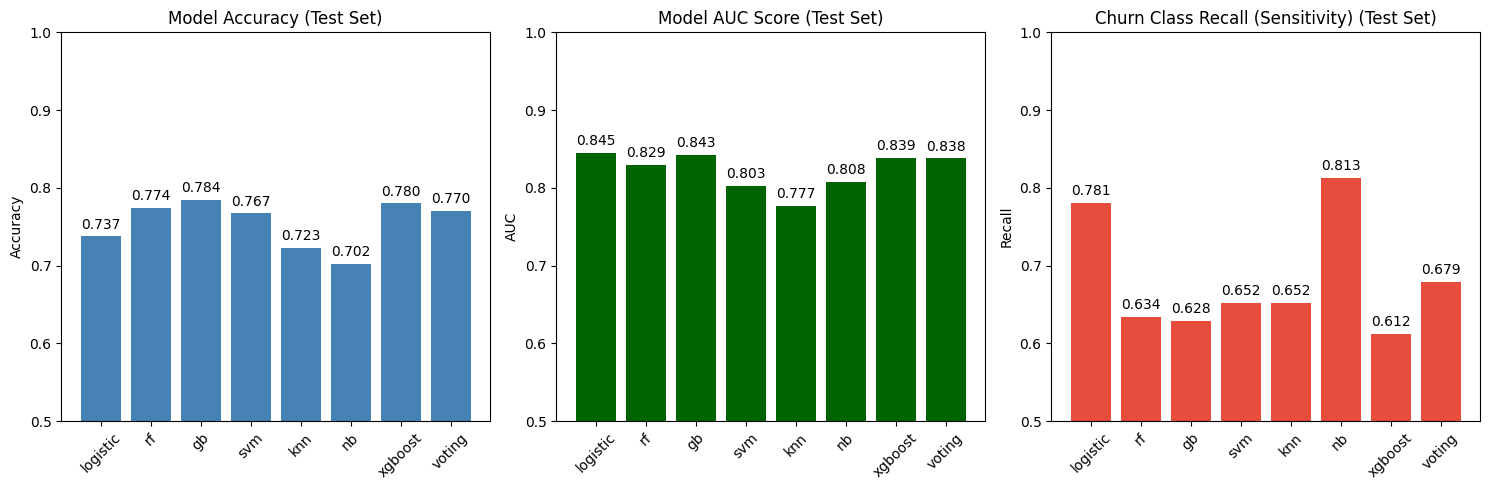

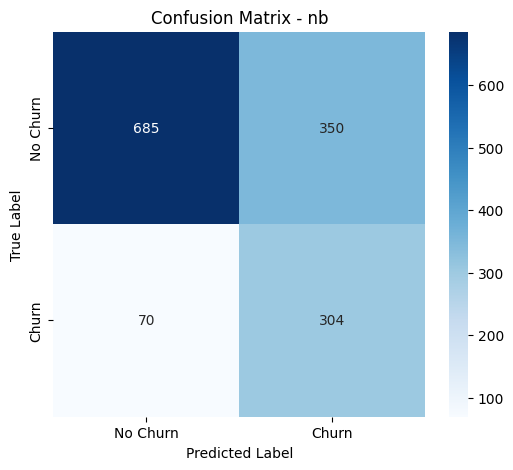


📊 Classification Report - nb:
              precision    recall  f1-score   support

    No Churn       0.91      0.66      0.77      1035
       Churn       0.46      0.81      0.59       374

    accuracy                           0.70      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.70      0.72      1409



In [3]:
filepath = 'E:\Python\Costumer Churn\WA_Fn-UseC_-Telco-Customer-Churn.csv' 

#Full pipeline with exploration
results = ChurnPipeline(filepath).run()

In [ ]:
results_df = pd.DataFrame(results['all_results']).T
round(results_df*100, 2).sort_values('test_auc', ascending=False)

,test_accuracy,test_auc,test_recall,cv_accuracy,cv_auc,cv_recall
logistic,73.74,84.49,78.07,77.18,85.24,80.26
gb,78.42,84.25,62.83,85.49,93.53,85.70
xgboost,78.00,83.90,61.23,85.89,93.72,85.77
voting,77.00,83.78,67.91,NaN,NaN,NaN
rf,77.43,82.92,63.37,85.66,92.53,87.63
nb,70.19,80.76,81.28,74.84,82.24,83.14
svm,76.72,80.28,65.24,83.84,91.34,88.62
knn,72.32,77.66,65.24,82.45,90.11,90.82


In [ ]:
#Compare what works best
comparison = compare_configurations(filepath)


Testing: Baseline
Best Model: nb
AUC: 0.808
Accuracy: 0.696
Churn Recall: 0.840

Testing: With SMOTE
Best Model: nb
AUC: 0.807
Accuracy: 0.696
Churn Recall: 0.821

Testing: With Features
Best Model: nb
AUC: 0.807
Accuracy: 0.703
Churn Recall: 0.816

Testing: Full Pipeline
Best Model: nb
AUC: 0.808
Accuracy: 0.702
Churn Recall: 0.813
